Dominant Frequency = 0.1429 Hz
Damping Coefficient β = 1.1991 1/s


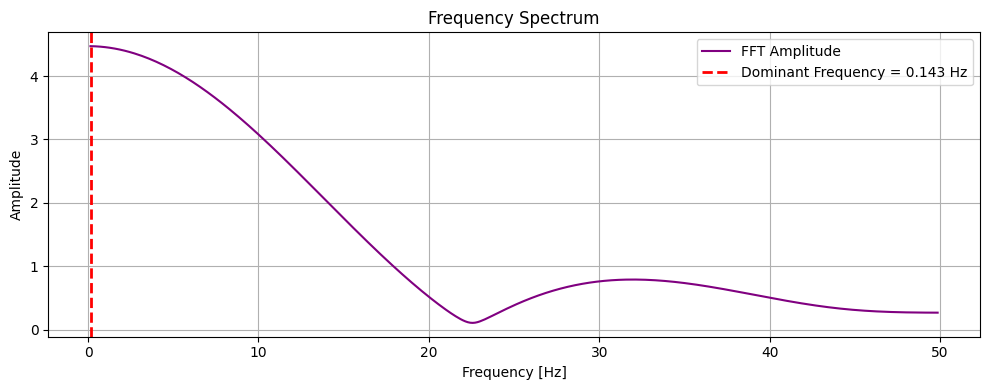

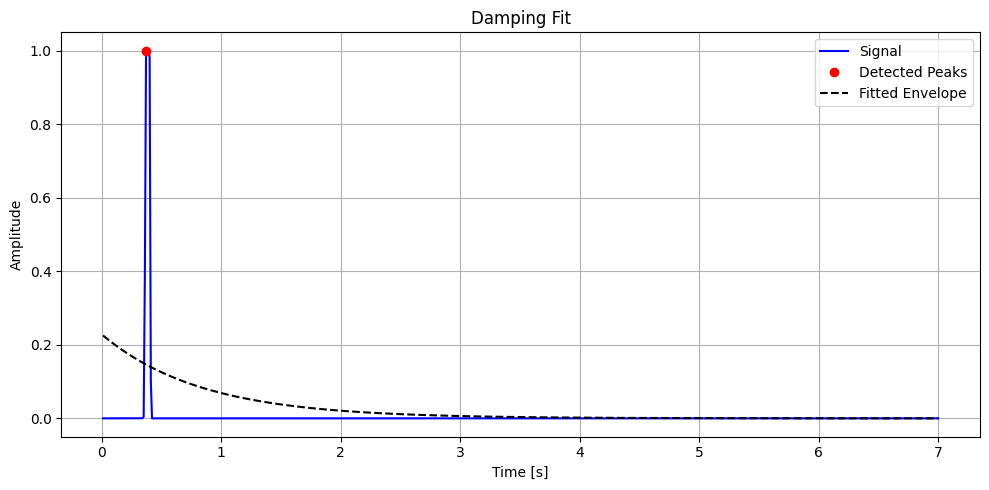

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq

file_name = "ProbeDataHoney.csv"
time_col = "Time"
alpha_col = "avg(alpha.honey)"

# Load CSV
df = pd.read_csv(file_name)
time = df[time_col].to_numpy()
alpha = df[alpha_col].to_numpy()

alpha_centered = alpha - np.mean(alpha)

# FFT to Get Dominant Frequency 
dt = time[1] - time[0]
fft_vals = fft(alpha_centered)
freqs = fftfreq(len(time), d=dt)

positive_freqs = freqs[freqs > 0]
positive_fft = np.abs(fft_vals[freqs > 0])

# Find dominant frequency
dominant_idx = np.argmax(positive_fft)
dominant_freq = positive_freqs[dominant_idx]
print(f"Dominant Frequency = {dominant_freq:.4f} Hz")

# Hilbert Envelope 
analytic_signal = hilbert(alpha_centered)
amplitude_envelope = np.abs(analytic_signal)

# Detect Peaks 
peaks, _ = find_peaks(alpha, distance=5, prominence=0.00001)
peak_times = time[peaks]
peak_values = alpha[peaks]

# Exponential Decay Fit
def exp_decay(t, A0, beta):
    return A0 * np.exp(-beta * t)

time_fit = time
envelope_fit = amplitude_envelope

popt, _ = curve_fit(exp_decay, time_fit, envelope_fit, p0=(envelope_fit[0], 0.1))
A0_fit, beta_fit = popt
print(f"Damping Coefficient β = {beta_fit:.4f} 1/s")

# === PLOT 1: Frequency Spectrum ===
plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, positive_fft, color='purple', label="FFT Amplitude")
plt.axvline(dominant_freq, color='red', linestyle='--', linewidth=2,
            label=f"Dominant Frequency = {dominant_freq:.3f} Hz")
plt.title("Frequency Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("FrequencySpectrum_Honey1.png", dpi=300, bbox_inches='tight')
plt.show()

# === PLOT 2: Signal, Peaks, and Fitted Envelope Only ===
plt.figure(figsize=(10, 5))
plt.plot(time, alpha, label="Signal", color='blue')          # Signal
plt.plot(peak_times, peak_values, 'ro', label="Detected Peaks") # Peaks
plt.plot(time, exp_decay(time, *popt), '--', color='black', label="Fitted Envelope")  # Fitted envelope
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Damping Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("DampingFit_Honey.png", dpi=300, bbox_inches='tight')
plt.show()
